# Módulos útiles para ficheros grib

Esta foto puede representar la jerarquía de paquetes que vamos a usar en este curso:

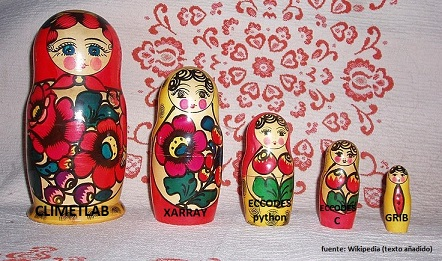

## Instalación

### Instalación de eccodes utilizando CMake

In [ ]:
!wget https://confluence.ecmwf.int/download/attachments/45757960/eccodes-2.30.0-Source.tar.gz?api=v2 -O eccodes-2.30.0-Source.tar.gz
!tar -xzf  /content/eccodes-2.30.0-Source.tar.gz
!mkdir build ; cd build
%cd build
!cmake -DCMAKE_INSTALL_PREFIX=eccodes ../eccodes-2.30.0-Source
!make -j 4
!make install
%cd /content

In [ ]:
import os
PATH = os.getenv('PATH')
os.environ['PATH'] = PATH + ':/content/build/eccodes/bin'

In [ ]:
!wget https://github.com/waveology/tests/raw/main/local_grib_definitions.rar
!wget https://github.com/waveology/tests/raw/main/data.grib
!unrar x -o+ /content/local_grib_definitions.rar

In [ ]:
!codes_info

In [ ]:
os.environ['GRIB_DEFINITION_PATH'] = '/content/local_grib_definitions:/usr/local/share/grib_api/definitions'

### Instalación de eccodes con Conda

In [ ]:
!wget https://github.com/waveology/tests/raw/main/local_grib_definitions.rar
!wget https://github.com/waveology/tests/raw/main/data.grib
!unrar x -o+ /content/local_grib_definitions.rar && rm -rf /content/local_grib_definitions.rar

In [ ]:
!pip install -q condacolab
import condacolab
condacolab.install() # expect a kernel restart

In [ ]:
!conda install -q eccodes -c conda-forge

In [ ]:
!codes_info

In [ ]:
import os
os.environ['GRIB_DEFINITION_PATH'] = '/content/local_grib_definitions:/usr/local/share/grib_api/definitions'
!echo $GRIB_DEFINITION_PATH

### Instalación de climetlab

In [ ]:
!pip install climetlab

## Grib_tools

## Módulo eccodes

## Módulo xarray

## Módulo climetlab